## 2. Reuters 딥러닝 모델

- 로이터 뉴스 기사 데이터셋
- 8,982개의 훈련 데이터셋과 2,246개의 테스트 데이터셋으로 구분
- 뉴스 기사의 주제로 46개 레이블

이번 스텝에서는 8번 노드에 나왔던 모델과 동일한 모델을 실습합니다.   
하지만 다양한 성능 향상 방법을 사용하여 8번 노드에서의 딥러닝 모델보다 성능을 더 높일 수 있습니다.   
8번 노드에서 사용했던 ReLU와는 다른 활성화함수를 사용해보고, BatchNormalization과 Dropout을 적용해 봅시다.   
ModelCheckpoint와 EarlyStopping 콜백 함수도 적용해 보세요.

### 데이터 로드 및 전처리
- reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다. 
- 데이터셋은 keras.datasets에서 불러올 수 있는 reuters 데이터 셋을 활용하고, 이때 파라미터 조정을 통해 단어의 개수는 10000개로 제한합니다(num_words=10000).
- 데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용합니다.
- 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [4]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.25, random_state=123)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(x_train))
print(len(x_val))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


- 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다. 원-핫 인코딩 함수를 직접 만들어보세요.
- 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.

In [14]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.

def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, d in enumerate(data):
        results[i, d] = 1.
    return results

x_train = one_hot_encoding(x_train)
x_val = one_hot_encoding(x_val)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(y_train, num_classes=46)
y_val = utils.to_categorical(y_val, num_classes=46)
y_test = utils.to_categorical(test_labels, num_classes=46)

IndexError: arrays used as indices must be of integer (or boolean) type

### 모델 구성 및 컴파일
- BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성합니다.
- 층 배열 순서 : 입력 -dense-batchnormalization-activation-dropout -dense-batchnormalization-activation-dropout -output(dense)
- [활성화 함수의 종류와 사용 이유](https://kevinitcoding.tistory.com/entry/%ED%99%9C%EC%84%B1%ED%99%94-%ED%95%A8%EC%88%98-%EC%A0%95%EC%9D%98%EC%99%80-%EC%A2%85%EB%A5%98-%EB%B9%84%EC%84%A0%ED%98%95-%ED%95%A8%EC%88%98%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%B4%EC%95%BC-%ED%95%98%EB%8A%94-%EC%9D%B4%EC%9C%A0)

In [8]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.

import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax', name='output'))

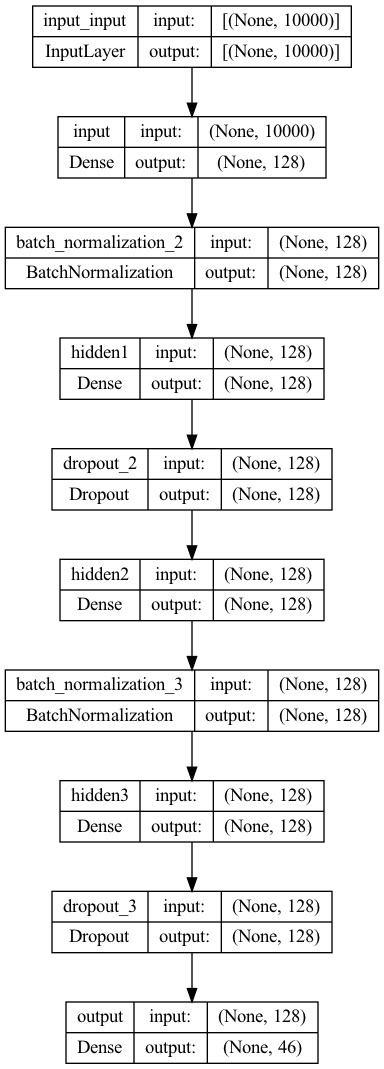

In [9]:
utils.plot_model(model, show_shapes=True)

In [10]:
# 모델 컴파일
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 hidden1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 hidden2 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                     

### 모델 학습
ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.

In [11]:
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

ValueError: Data cardinality is ambiguous:
  x sizes: 8982
  y sizes: 6736
Make sure all arrays contain the same number of samples.

- 모든 오류의 원인은 처음의 train, test 나누는 부분이 없었던 것.
- 반영하여 처음부터 다시 작성!
---

### 데이터 로드 및 전처리
- reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다. 
- 데이터셋은 keras.datasets에서 불러올 수 있는 reuters 데이터 셋을 활용하고, 이때 파라미터 조정을 통해 단어의 개수는 10000개로 제한합니다(num_words=10000).
- 데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용합니다.
- 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [23]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
# reuters 데이터셋을 로드
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000, test_split=0.2)

# 훈련, 검증 데이터 분리
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=123)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


- 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다. 원-핫 인코딩 함수를 직접 만들어보세요.
- 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.

In [24]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, d in enumerate(data):
        results[i, d] = 1.
    return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

### 모델 구성 및 컴파일
- BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성합니다.
- 층 배열 순서 : 입력 -dense-batchnormalization-activation-dropout -dense-batchnormalization-activation-dropout -output(dense)
- [활성화 함수의 종류와 사용 이유](https://kevinitcoding.tistory.com/entry/%ED%99%9C%EC%84%B1%ED%99%94-%ED%95%A8%EC%88%98-%EC%A0%95%EC%9D%98%EC%99%80-%EC%A2%85%EB%A5%98-%EB%B9%84%EC%84%A0%ED%98%95-%ED%95%A8%EC%88%98%EB%A5%BC-%EC%82%AC%EC%9A%A9%ED%95%B4%EC%95%BC-%ED%95%98%EB%8A%94-%EC%9D%B4%EC%9C%A0)

In [27]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax', name='output'))

In [28]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 hidden1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 hidden2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNormalization)                                     

### 모델 학습
ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.

In [29]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=100, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/100
14/14 [==============================] - 1s 24ms/step - loss: 2.5419 - accuracy: 0.4526 - val_loss: 2.3115 - val_accuracy: 0.6923
Epoch 2/100
11/14 [======================>.......] - ETA: 0s - loss: 1.4577 - accuracy: 0.6992

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 15ms/step - loss: 1.4510 - accuracy: 0.7020 - val_loss: 1.9018 - val_accuracy: 0.7199
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 1.0993 - accuracy: 0.7681 - val_loss: 1.7185 - val_accuracy: 0.6888
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 0.8805 - accuracy: 0.8107 - val_loss: 1.6378 - val_accuracy: 0.6572
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.7308 - accuracy: 0.8394 - val_loss: 1.4339 - val_accuracy: 0.6923
Epoch 6/100
14/14 [==============================] - 0s 13ms/step - loss: 0.6209 - accuracy: 0.8624 - val_loss: 1.4630 - val_accuracy: 0.6460
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5325 - accuracy: 0.8827 - val_loss: 1.4309 - val_accuracy: 0.6518
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.4618 - accuracy: 0.8940 - val_loss: 1.4229 - val_accuracy: 0.6549
Epoch 9/100
14/14 

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

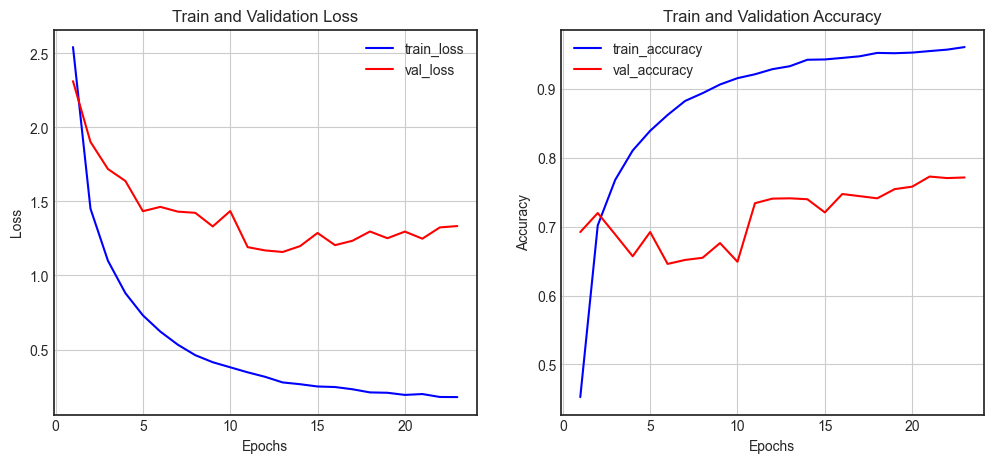

In [30]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

### 모델 평가 및 예측
테스트 데이터셋을 이용해 모델을 평가합니다.

In [31]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 824us/step - loss: 1.1402 - accuracy: 0.7404


[1.140168309211731, 0.7404274344444275]

- 결과 : loss를 더 떨어트리고, 정확도를 높이기 위해 학습이 더 잘 되어야 할 것으로 보임.  
- 재시도 : 층을 더 많이 쌓아보기로 함
---

In [32]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

In [33]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 hidden1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 hidden2 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_9 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [34]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=20,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=100, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/100
14/14 [==============================] - 1s 25ms/step - loss: 2.1326 - accuracy: 0.5413 - val_loss: 2.3034 - val_accuracy: 0.6687
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 1.1753 - accuracy: 0.7386

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 17ms/step - loss: 1.1785 - accuracy: 0.7377 - val_loss: 1.9712 - val_accuracy: 0.7150
Epoch 3/100
14/14 [==============================] - 0s 17ms/step - loss: 0.8677 - accuracy: 0.7981 - val_loss: 1.7046 - val_accuracy: 0.6968
Epoch 4/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6952 - accuracy: 0.8337 - val_loss: 1.3904 - val_accuracy: 0.7289
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5388 - accuracy: 0.8729 - val_loss: 1.3377 - val_accuracy: 0.6812
Epoch 6/100
14/14 [==============================] - 0s 17ms/step - loss: 0.4405 - accuracy: 0.8913 - val_loss: 1.1953 - val_accuracy: 0.7346
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.3632 - accuracy: 0.9120 - val_loss: 1.1545 - val_accuracy: 0.7240
Epoch 8/100
14/14 [==============================] - 0s 18ms/step - loss: 0.3166 - accuracy: 0.9235 - val_loss: 1.1213 - val_accuracy: 0.7364
Epoch 9/100
14/14 

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

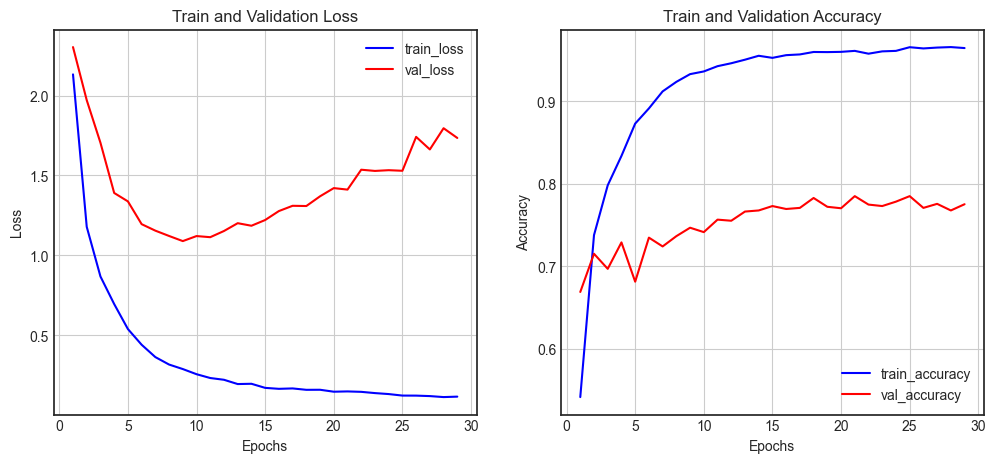

In [35]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [36]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 868us/step - loss: 1.0883 - accuracy: 0.7507


[1.0883499383926392, 0.7506678700447083]

- 변경사항 : 1층 더 쌓고, 유닛을 늘림, patience=20으로 올림
- 결과 : loss가 다시 상승함
- 재시도 : patience=10으로 다시 바꾸기. 3개 층은 relu로 바꾸기
---

In [43]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

In [44]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 hidden2 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_13 (Ba  (None, 256)               1024      
 tchNormalization)                                    

In [45]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=100, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/100
14/14 [==============================] - 1s 23ms/step - loss: 2.4442 - accuracy: 0.4604 - val_loss: 3.1452 - val_accuracy: 0.6376
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.4743 - accuracy: 0.6682

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 17ms/step - loss: 1.4743 - accuracy: 0.6682 - val_loss: 2.8127 - val_accuracy: 0.6460
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 1.1660 - accuracy: 0.7267 - val_loss: 2.5453 - val_accuracy: 0.6371
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 0.9599 - accuracy: 0.7702 - val_loss: 2.0630 - val_accuracy: 0.6509
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.8015 - accuracy: 0.8082 - val_loss: 1.8555 - val_accuracy: 0.6518
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6742 - accuracy: 0.8385 - val_loss: 1.6303 - val_accuracy: 0.6443
Epoch 7/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5805 - accuracy: 0.8581 - val_loss: 1.4452 - val_accuracy: 0.6527
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5097 - accuracy: 0.8711 - val_loss: 1.3615 - val_accuracy: 0.6785
Epoch 9/100
14/14 

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

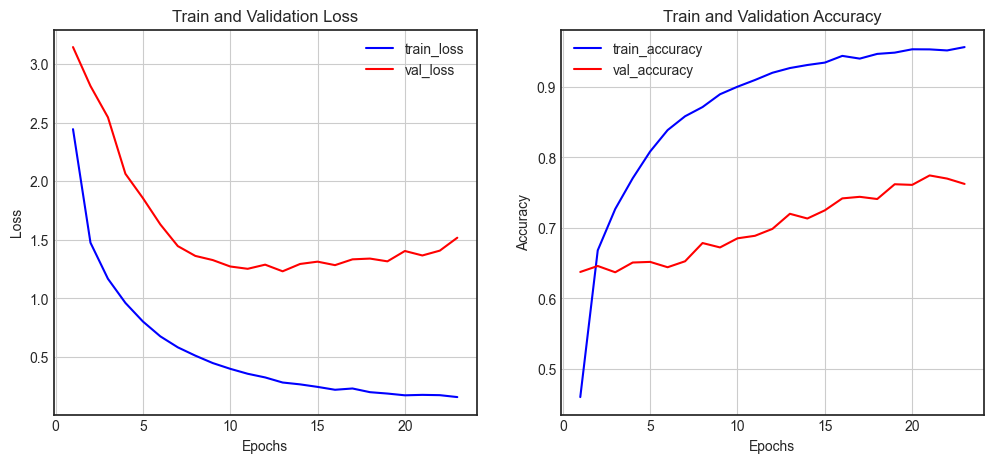

In [46]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [47]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 846us/step - loss: 1.2548 - accuracy: 0.7226


[1.2548198699951172, 0.7226179838180542]

- 결과 : elu 함수 사용할 때의 정확도, loss 수치가 더 좋음.
- 변경사항 : 다시 elu로 바꾸기 / 여러 층 쌓되 유닛 수는 줄여보기
---

In [55]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_20 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 hidden2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_21 (Ba  (None, 64)                256       
 tchNormalization)                                   

In [56]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
14/14 [==============================] - 1s 21ms/step - loss: 2.4685 - accuracy: 0.4610 - val_loss: 2.2495 - val_accuracy: 0.6469
Epoch 2/60
11/14 [======================>.......] - ETA: 0s - loss: 1.4986 - accuracy: 0.6797

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 15ms/step - loss: 1.4726 - accuracy: 0.6866 - val_loss: 1.7274 - val_accuracy: 0.6848
Epoch 3/60
14/14 [==============================] - 0s 17ms/step - loss: 1.1658 - accuracy: 0.7401 - val_loss: 1.6313 - val_accuracy: 0.6986
Epoch 4/60
14/14 [==============================] - 0s 15ms/step - loss: 0.9954 - accuracy: 0.7703 - val_loss: 1.5793 - val_accuracy: 0.6264
Epoch 5/60
14/14 [==============================] - 0s 15ms/step - loss: 0.8579 - accuracy: 0.7985 - val_loss: 1.3742 - val_accuracy: 0.6999
Epoch 6/60
14/14 [==============================] - 0s 14ms/step - loss: 0.7618 - accuracy: 0.8208 - val_loss: 1.3851 - val_accuracy: 0.6759
Epoch 7/60
14/14 [==============================] - 0s 15ms/step - loss: 0.6702 - accuracy: 0.8417 - val_loss: 1.3087 - val_accuracy: 0.6923
Epoch 8/60
14/14 [==============================] - 0s 16ms/step - loss: 0.6102 - accuracy: 0.8483 - val_loss: 1.3068 - val_accuracy: 0.6928
Epoch 9/60
14/14 [======

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

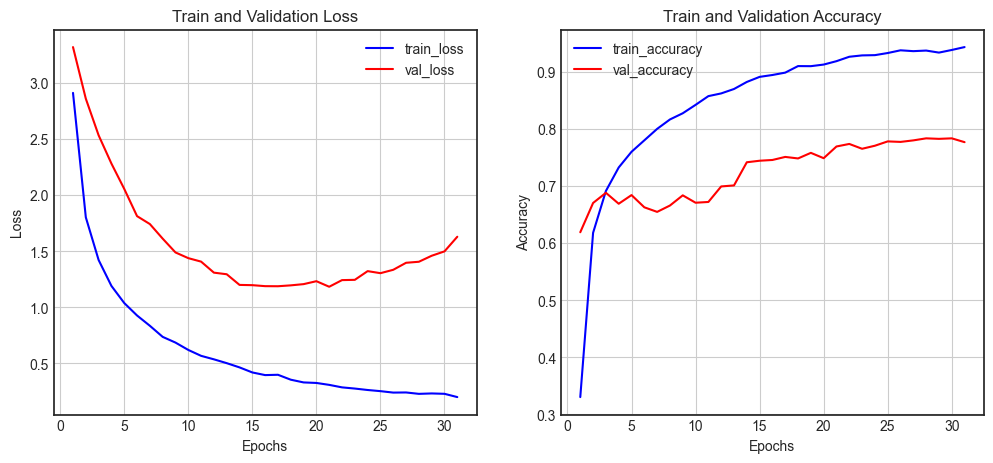

In [51]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [52]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 750us/step - loss: 1.1792 - accuracy: 0.7658


[1.1792495250701904, 0.7658059000968933]

- 변동사항 : 유닛수 줄이기, 에폭 60으로 줄이기
- 결과 : loss, accuracy 수치 모두 향상됨.
- 재시도 : 드롭아웃 1층 삭제해보기
---

In [57]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden3'))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_22 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 hidden2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_23 (Ba  (None, 64)                256       
 tchNormalization)                                   

In [58]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
14/14 [==============================] - 1s 21ms/step - loss: 2.1156 - accuracy: 0.5601 - val_loss: 2.2001 - val_accuracy: 0.7119
Epoch 2/60
14/14 [==============================] - 0s 15ms/step - loss: 1.0990 - accuracy: 0.7580 - val_loss: 1.8949 - val_accuracy: 0.7012
Epoch 3/60
14/14 [==============================] - 0s 15ms/step - loss: 0.8053 - accuracy: 0.8128 - val_loss: 1.6075 - val_accuracy: 0.6683
Epoch 4/60
14/14 [==============================] - 0s 15ms/step - loss: 0.6374 - accuracy: 0.8472 - val_loss: 1.4457 - val_accuracy: 0.6941
Epoch 5/60
14/14 [==============================] - 0s 15ms/step - loss: 0.5062 - accuracy: 0.8784 - val_loss: 1.3821 - val_accuracy: 0.6728
Epoch 6/60
14/14 [==============================] - 0s 14ms/step - loss: 0.4245 - accuracy: 0.8974 - val_loss: 1.3838 - val_accuracy: 0.6492
Epoch 7/60
14/14 [==============================] - 0s 15ms/step - loss: 0.3454 - accuracy: 0.9185 - val_loss: 1.2353 - val_accuracy: 0.6919
Epoch 8/60
14

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

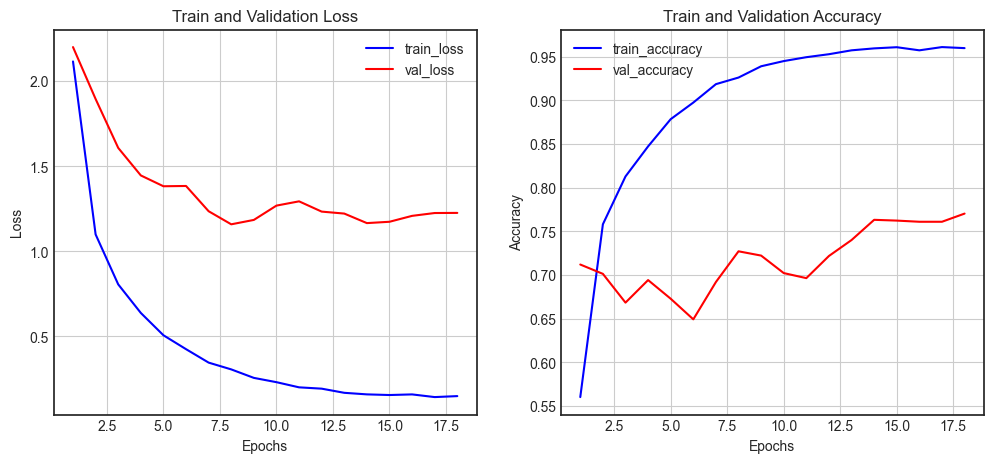

In [59]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [60]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 832us/step - loss: 1.1667 - accuracy: 0.7244


[1.1666849851608276, 0.7243989109992981]

- 결과 : 수치 나빠짐. 드롭아웃은 있는 것이 모델 성능에 좋은 것으로 판단.
- 재시도 : 드롭아웃 다시 만들고, 1층 더 깊게 쌓아보기
---

In [61]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden5'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_24 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 hidden2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_25 (Ba  (None, 64)                256       
 tchNormalization)                                   

In [62]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
14/14 [==============================] - 1s 37ms/step - loss: 2.6284 - accuracy: 0.4308 - val_loss: 2.1001 - val_accuracy: 0.6509
Epoch 2/60
13/14 [==========================>...] - ETA: 0s - loss: 1.6343 - accuracy: 0.6556

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 16ms/step - loss: 1.6339 - accuracy: 0.6553 - val_loss: 1.7454 - val_accuracy: 0.6812
Epoch 3/60
14/14 [==============================] - 0s 15ms/step - loss: 1.3311 - accuracy: 0.7105 - val_loss: 1.6174 - val_accuracy: 0.6714
Epoch 4/60
14/14 [==============================] - 0s 16ms/step - loss: 1.1325 - accuracy: 0.7482 - val_loss: 1.5168 - val_accuracy: 0.6772
Epoch 5/60
14/14 [==============================] - 0s 16ms/step - loss: 1.0098 - accuracy: 0.7657 - val_loss: 1.4431 - val_accuracy: 0.6821
Epoch 6/60
14/14 [==============================] - 0s 17ms/step - loss: 0.9018 - accuracy: 0.7868 - val_loss: 1.4540 - val_accuracy: 0.6723
Epoch 7/60
14/14 [==============================] - 0s 15ms/step - loss: 0.8145 - accuracy: 0.8064 - val_loss: 1.4872 - val_accuracy: 0.6558
Epoch 8/60
14/14 [==============================] - 0s 16ms/step - loss: 0.7639 - accuracy: 0.8170 - val_loss: 1.3445 - val_accuracy: 0.7066
Epoch 9/60
14/14 [======

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

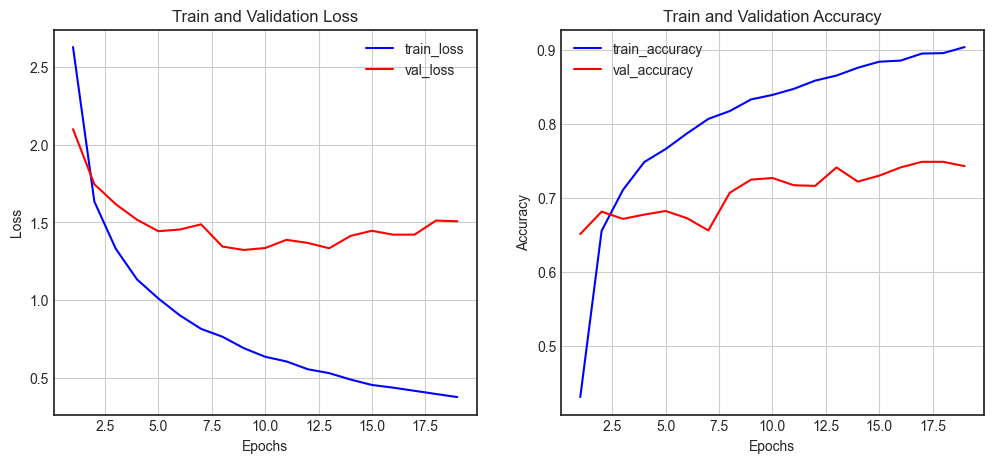

In [63]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [64]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 826us/step - loss: 1.2677 - accuracy: 0.7266


[1.2677024602890015, 0.7266250848770142]

---

In [65]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(64, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 64)                640064    
                                                                 
 batch_normalization_27 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 hidden2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_28 (Ba  (None, 64)                256       
 tchNormalization)                                   

In [66]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
14/14 [==============================] - 1s 17ms/step - loss: 2.5770 - accuracy: 0.4430 - val_loss: 2.4733 - val_accuracy: 0.6456
Epoch 2/60
14/14 [==============================] - 0s 11ms/step - loss: 1.5206 - accuracy: 0.6749 - val_loss: 1.9447 - val_accuracy: 0.6714
Epoch 3/60
 1/14 [=>............................] - ETA: 0s - loss: 1.2949 - accuracy: 0.7109

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 11ms/step - loss: 1.2277 - accuracy: 0.7233 - val_loss: 1.6824 - val_accuracy: 0.6621
Epoch 4/60
14/14 [==============================] - 0s 11ms/step - loss: 1.0432 - accuracy: 0.7608 - val_loss: 1.5388 - val_accuracy: 0.6714
Epoch 5/60
14/14 [==============================] - 0s 11ms/step - loss: 0.8902 - accuracy: 0.7913 - val_loss: 1.4919 - val_accuracy: 0.6438
Epoch 6/60
14/14 [==============================] - 0s 11ms/step - loss: 0.7870 - accuracy: 0.8135 - val_loss: 1.4025 - val_accuracy: 0.6741
Epoch 7/60
14/14 [==============================] - 0s 11ms/step - loss: 0.6998 - accuracy: 0.8273 - val_loss: 1.3245 - val_accuracy: 0.6861
Epoch 8/60
14/14 [==============================] - 0s 11ms/step - loss: 0.6216 - accuracy: 0.8455 - val_loss: 1.3885 - val_accuracy: 0.6549
Epoch 9/60
14/14 [==============================] - 0s 11ms/step - loss: 0.5712 - accuracy: 0.8558 - val_loss: 1.3530 - val_accuracy: 0.6598
Epoch 10/60
14/14 [=====

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

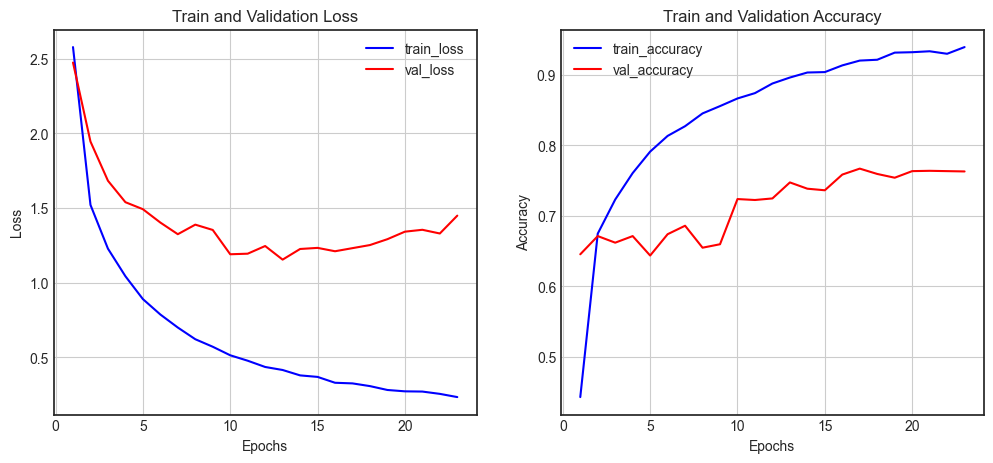

In [67]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [68]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 654us/step - loss: 1.1471 - accuracy: 0.7440


[1.1470682621002197, 0.7439892888069153]

In [69]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_29 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 hidden2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_30 (Ba  (None, 64)                256       
 tchNormalization)                                   

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 15ms/step - loss: 1.4373 - accuracy: 0.6936 - val_loss: 1.8728 - val_accuracy: 0.6313
Epoch 3/60
14/14 [==============================] - 0s 14ms/step - loss: 1.1620 - accuracy: 0.7423 - val_loss: 1.6144 - val_accuracy: 0.6411
Epoch 4/60
14/14 [==============================] - 0s 15ms/step - loss: 0.9789 - accuracy: 0.7739 - val_loss: 1.5812 - val_accuracy: 0.6211
Epoch 5/60
14/14 [==============================] - 0s 14ms/step - loss: 0.8329 - accuracy: 0.7984 - val_loss: 1.5458 - val_accuracy: 0.6193
Epoch 6/60
14/14 [==============================] - 0s 14ms/step - loss: 0.7403 - accuracy: 0.8204 - val_loss: 1.3909 - val_accuracy: 0.6687
Epoch 7/60
14/14 [==============================] - 0s 14ms/step - loss: 0.6754 - accuracy: 0.8358 - val_loss: 1.2833 - val_accuracy: 0.7030
Epoch 8/60
14/14 [==============================] - 0s 14ms/step - loss: 0.5846 - accuracy: 0.8544 - val_loss: 1.3129 - val_accuracy: 0.6848
Epoch 9/60
14/14 [======

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

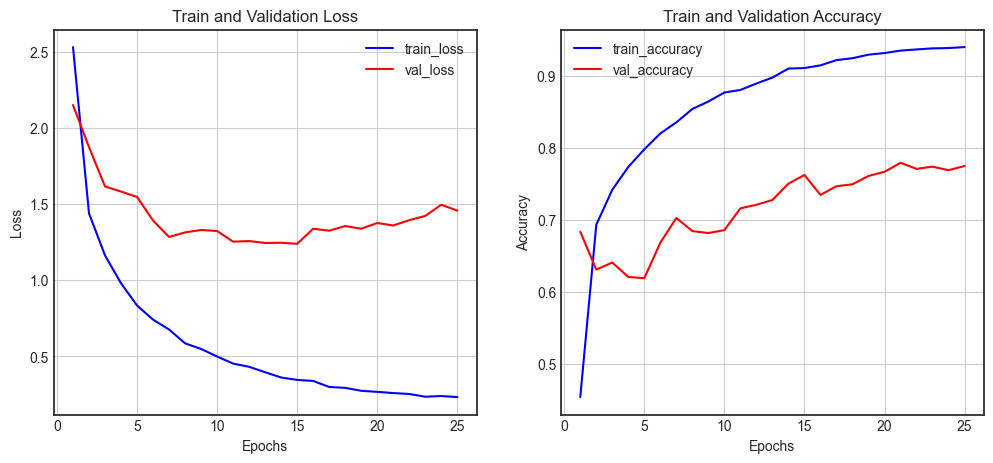

In [70]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [71]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 797us/step - loss: 1.1758 - accuracy: 0.7654


[1.1757510900497437, 0.7653606534004211]

In [72]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=1024,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_31 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 hidden2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_32 (Ba  (None, 64)                256       
 tchNormalization)                                   

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 24ms/step - loss: 1.3245 - accuracy: 0.7150 - val_loss: 1.8870 - val_accuracy: 0.7133
Epoch 4/60
7/7 [==============================] - 0s 24ms/step - loss: 1.1136 - accuracy: 0.7525 - val_loss: 1.7116 - val_accuracy: 0.7053
Epoch 5/60
7/7 [==============================] - 0s 24ms/step - loss: 0.9759 - accuracy: 0.7705 - val_loss: 1.6715 - val_accuracy: 0.6941
Epoch 6/60
7/7 [==============================] - 0s 24ms/step - loss: 0.8684 - accuracy: 0.7969 - val_loss: 1.5328 - val_accuracy: 0.7133
Epoch 7/60
7/7 [==============================] - 0s 23ms/step - loss: 0.7863 - accuracy: 0.8141 - val_loss: 1.5662 - val_accuracy: 0.6576
Epoch 8/60
7/7 [==============================] - 0s 24ms/step - loss: 0.7026 - accuracy: 0.8272 - val_loss: 1.5196 - val_accuracy: 0.6638
Epoch 9/60
7/7 [==============================] - 0s 24ms/step - loss: 0.6440 - accuracy: 0.8429 - val_loss: 1.4940 - val_accuracy: 0.6558
Epoch 10/60
7/7 [=====================

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

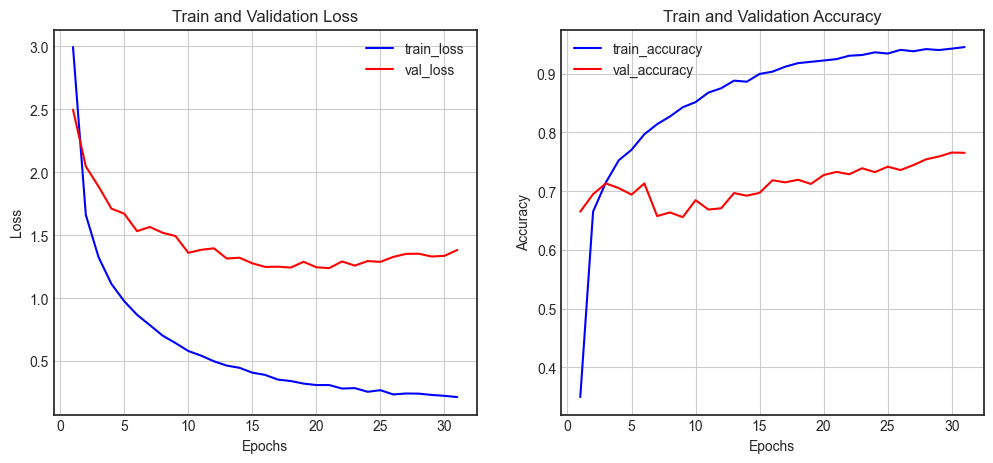

In [73]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [74]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 788us/step - loss: 1.2638 - accuracy: 0.7342


[1.2638375759124756, 0.7341940999031067]

- 배치 사이즈 1024로 늘렸더니 수치 소폭 하락.
- 마지막 재도전 : 유닛수 늘리고, L2 규제
---

In [76]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, kernel_regularizer='l2', activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_35 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 hidden2 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_36 (Ba  (None, 128)               512       
 tchNormalization)                                   

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

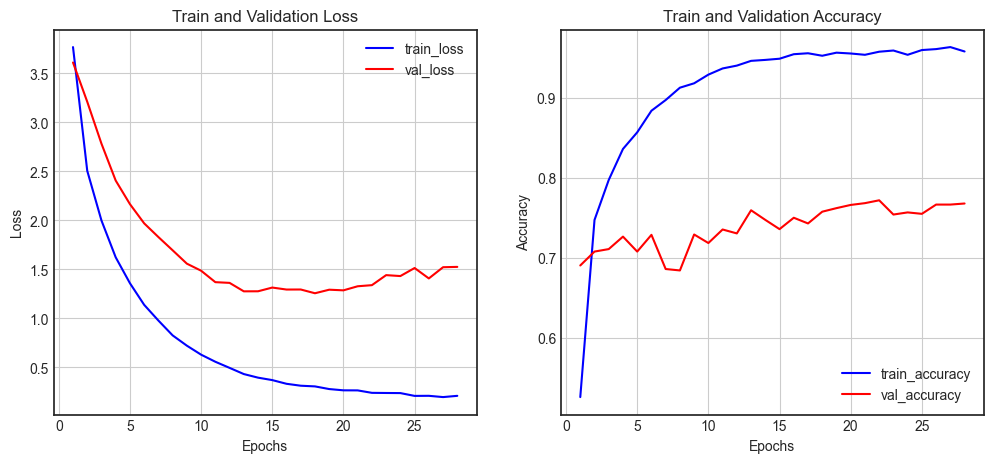

In [77]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [78]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 918us/step - loss: 1.2488 - accuracy: 0.7654


[1.248786449432373, 0.7653606534004211]

In [79]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, kernel_regularizer='l2', activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_37 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 hidden2 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_38 (Ba  (None, 256)               1024      
 tchNormalization)                                   

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 17ms/step - loss: 2.4467 - accuracy: 0.7558 - val_loss: 3.2846 - val_accuracy: 0.7146
Epoch 3/60
14/14 [==============================] - 0s 17ms/step - loss: 1.9288 - accuracy: 0.8223 - val_loss: 2.8655 - val_accuracy: 0.7342
Epoch 4/60
14/14 [==============================] - 0s 17ms/step - loss: 1.5642 - accuracy: 0.8594 - val_loss: 2.4446 - val_accuracy: 0.7039
Epoch 5/60
14/14 [==============================] - 0s 17ms/step - loss: 1.2767 - accuracy: 0.8903 - val_loss: 2.1300 - val_accuracy: 0.7244
Epoch 6/60
14/14 [==============================] - 0s 17ms/step - loss: 1.0778 - accuracy: 0.9129 - val_loss: 1.9269 - val_accuracy: 0.7119
Epoch 7/60
14/14 [==============================] - 0s 17ms/step - loss: 0.9094 - accuracy: 0.9265 - val_loss: 1.7833 - val_accuracy: 0.7093
Epoch 8/60
14/14 [==============================] - 0s 18ms/step - loss: 0.7666 - accuracy: 0.9390 - val_loss: 1.6316 - val_accuracy: 0.7168
Epoch 9/60
14/14 [======

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

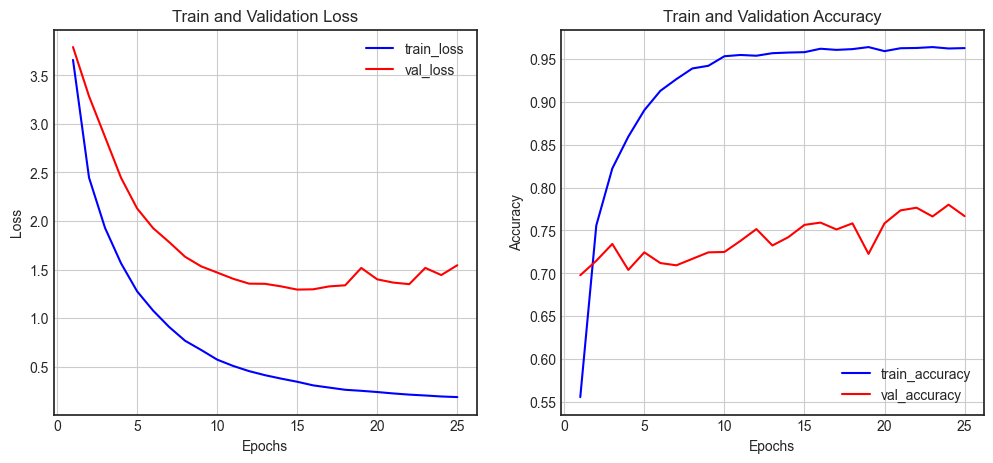

In [80]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [81]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 995us/step - loss: 1.2885 - accuracy: 0.7529


[1.2885349988937378, 0.7528940439224243]

In [82]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, kernel_regularizer='l2', activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, kernel_regularizer='l2', activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, kernel_regularizer='l2', activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_39 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 hidden2 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_40 (Ba  (None, 256)               1024      
 tchNormalization)                                   

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 17ms/step - loss: 5.6703 - accuracy: 0.7568 - val_loss: 6.2753 - val_accuracy: 0.7057
Epoch 3/60
14/14 [==============================] - 0s 17ms/step - loss: 4.5900 - accuracy: 0.8248 - val_loss: 5.3946 - val_accuracy: 0.6589
Epoch 4/60
14/14 [==============================] - 0s 18ms/step - loss: 3.7453 - accuracy: 0.8642 - val_loss: 4.7318 - val_accuracy: 0.6073
Epoch 5/60
14/14 [==============================] - 0s 18ms/step - loss: 3.0736 - accuracy: 0.8946 - val_loss: 4.0886 - val_accuracy: 0.6300
Epoch 6/60
14/14 [==============================] - 0s 18ms/step - loss: 2.4805 - accuracy: 0.9176 - val_loss: 3.6676 - val_accuracy: 0.6256
Epoch 7/60
14/14 [==============================] - 0s 18ms/step - loss: 2.0167 - accuracy: 0.9344 - val_loss: 3.2309 - val_accuracy: 0.6028
Epoch 8/60
14/14 [==============================] - 0s 19ms/step - loss: 1.6230 - accuracy: 0.9405 - val_loss: 2.8863 - val_accuracy: 0.5623
Epoch 9/60
14/14 [======

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

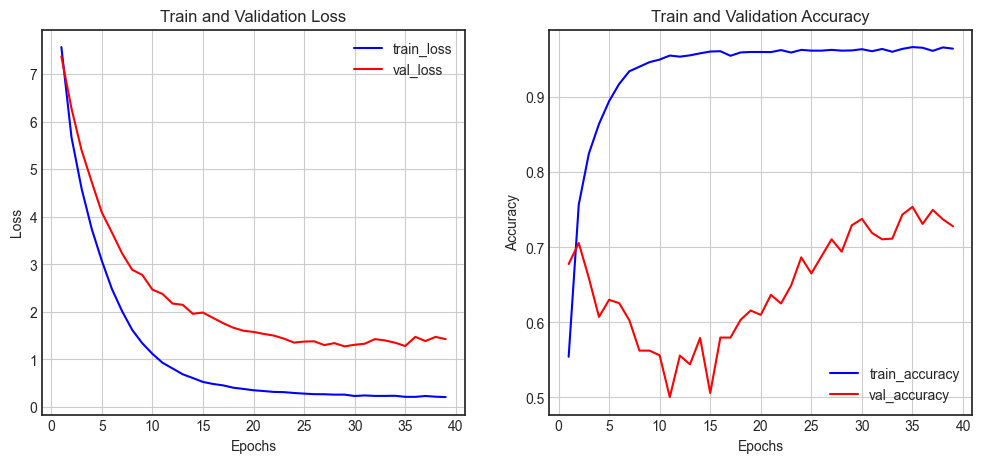

In [83]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [84]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 972us/step - loss: 1.2509 - accuracy: 0.7311


[1.2508790493011475, 0.7310774922370911]

In [85]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
import tensorflow as tf

model = models.Sequential()
model.add(layers.Dense(128, activation='elu', input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, kernel_regularizer='l2', activation='elu', name='hidden1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, kernel_regularizer='l2', activation='elu', name='hidden2'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, kernel_regularizer='l2', activation='elu', name='hidden3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='elu', name='hidden4'))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('reuters.h5',
                                          save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                           monitor='val_loss',
                                           restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, batch_size=512,
                   validation_data=(x_val, y_val),
                   callbacks=[check_point_cb, early_stopping_cb])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization_41 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 hidden1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 hidden2 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_42 (Ba  (None, 256)               1024      
 tchNormalization)                                   

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 18ms/step - loss: 6.1041 - accuracy: 0.7801 - val_loss: 6.7996 - val_accuracy: 0.7337
Epoch 3/60
14/14 [==============================] - 0s 19ms/step - loss: 4.9001 - accuracy: 0.8461 - val_loss: 5.7288 - val_accuracy: 0.6990
Epoch 4/60
14/14 [==============================] - 0s 18ms/step - loss: 3.9448 - accuracy: 0.8890 - val_loss: 4.8484 - val_accuracy: 0.6687
Epoch 5/60
14/14 [==============================] - 0s 18ms/step - loss: 3.1451 - accuracy: 0.9192 - val_loss: 4.1475 - val_accuracy: 0.5494
Epoch 6/60
14/14 [==============================] - 0s 18ms/step - loss: 2.4752 - accuracy: 0.9372 - val_loss: 3.6430 - val_accuracy: 0.5899
Epoch 7/60
14/14 [==============================] - 0s 18ms/step - loss: 1.9548 - accuracy: 0.9449 - val_loss: 3.1546 - val_accuracy: 0.5071
Epoch 8/60
14/14 [==============================] - 0s 18ms/step - loss: 1.5435 - accuracy: 0.9477 - val_loss: 2.9317 - val_accuracy: 0.5387
Epoch 9/60
14/14 [======

/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDep

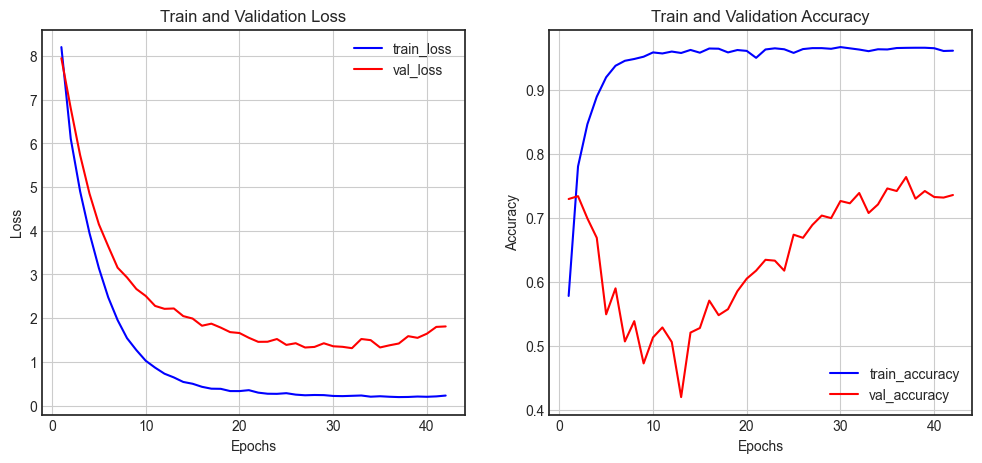

In [86]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [87]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 1ms/step - loss: 1.3154 - accuracy: 0.7382


[1.3154118061065674, 0.7382012605667114]

---

### 최종 결과 
52번 실험이 여러 시도들 중 가장 나은 수치와 가장 안정적인 그래프 모양을 보여줌.
- elu 보다 relu 함수가 더 적합한 경우로 보임
- 배치정규화와 드롭아웃(0.5)이 확실히 모델 성능에 기여함.
- 유닛수는 128에서 64, 46으로 점차 감소하는 식으로 구성하는 게 가장 좋음.

71/71 [==============================] - 0s 750us/step - loss: 1.1792 - accuracy: 0.7658   
[1.1792495250701904, 0.7658059000968933]